In [87]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.widgets
import matplotlib.animation as animation
from matplotlib import colors
from colour import Color

## Auxilliary subroutines for the SIR simulation

In [88]:
def neighbourIndices(nType, rad = 1): #0 = Von Neumann, 1 = Moore, 2 = Hybrid
    indices = []
    if(nType == 0):
        indices = [[i, 0] for i in range(-rad, rad + 1)] + [[0,j] for j in range(-rad, rad + 1)]
    
    if(nType == 1):
        indices = [[i, j] for i in range(-rad, rad + 1) for j in range(-rad, rad + 1)]
        
    if(nType == 2):
        indices = [[i, j] for j in range(-rad, rad + 1) for i in range(abs(j) - rad, rad - abs(j) + 1)]
        
    indices.remove([0,0])
    
    return indices

def isInfected(unit, tauI):
    return (unit >= 1 and unit <=tauI)

def customCmap(tauI, tauR):
    Dcol = Color("#ffffff")
    Scol = Color("#000000")
    Icol1 = Color("#800000")
    Icol2 = Color("#dc0000")
    Rcol1 = Color("#ff7500")
    Rcol2 = Color("#ffff32")
    clist = [Scol] + list(Icol1.range_to(Icol2, tauI)) + list(Rcol1.range_to(Rcol2, tauR)) + [Dcol]
    clist = [c.hex for c in clist]
    
    return colors.ListedColormap(clist)
    

## Demonstration of various neighbourhood types


<IPython.core.display.Javascript object>


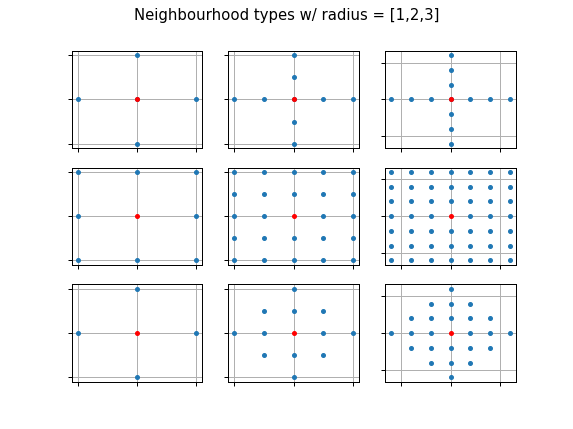

In [89]:
plt.close("all")
fig, axes = plt.subplots(3,3)
label = ["Von Neumann", "Moore", "Hybrid"]
for i in [0,1,2]:
    for j in [0,1,2]:
        ax = axes[i][j]
        x = np.array(neighbourIndices(i, j+1))[:,0]
        y = np.array(neighbourIndices(i, j+1))[:,1]
        
        ax.plot(x,y,"."); ax.plot(0,0, ".r");
        ax.set_xticklabels([]); ax.set_yticklabels([]);
        ax.grid(True)
        
        if(j == 0):
            ax.set_ylabel = label[i]
        
fig.suptitle("Neighbourhood types w/ radius = [1,2,3]")
plt.show()

### Simulation setup:
We model this situation using a cellular automaton with 3 states, characterized by an integer $\tau \in [0, \tau_0]$, such that $\tau_0 = \tau_I + \tau_R$, where $\tau_I$ is the period of infection and $\tau_R$ is the period of recovery/immunity.
* **Susceptible (S)** : $\tau = 0$
* **Infected (I)** : $\tau \in [1, \tau_I]$
* **Refractory (R)** : $\tau \in [\tau_I, \tau_0]$

The automaton evolves in the following way, which is a combination of stochastic and deterministic rules. The probability of **S** to transition to **I** is given by the ratio of infected neighbours, after which **I** deterministically increases by 1 every time-step till it transitions into **R** which then increases till it transitions to **S** when $\tau = \tau_0$, thus resetting the disease cycle.

$$\tau(t+1) = 
\begin{cases}
1, \text{ with probability q}, \\
0, \text{ with probability (1-q)}
\end{cases}
\text{ -----------      if     } \tau(t) = 0
$$

$$
\tau(t+1) = \tau(t) + 1 \text{ -----------     if     } 1\leq \tau(t) \leq \tau_0 - 1
$$

$$
\tau(t+1) = 0 \text{ -----------      if     } \tau(t) = \tau_0
$$

The **S** $\to$ **I** transition can be made deterministic by setting probability to 1, if any neighbour is infected. 

In [94]:
def SIRSmodel(n, tauI, tauR, mortality, nType, rad, bType, nsteps = 100, skip = 1, anim = True, init = ["random", 0.5, 50, 50]):
    plt.ioff()
    fig = plt.figure()
    grid = np.zeros((n,n)) #simulation grid
    
    #set colormap and colorbar
    cmap = customCmap(tauI, tauR)
    plt.colorbar(plt.imshow(grid, cmap=cmap, interpolation = 'nearest', vmin = 0, vmax = tauI+tauR+1))
    plt.ion()
    
    #data collection
    nS = np.zeros(nsteps)
    nI = np.zeros(nsteps)
    nR = np.zeros(nsteps)
    nD = np.zeros(nsteps)
    
    neighbours = np.zeros((n,n), dtype=object) #stores neighbours
    ims = []; #stores plots
    
    tau0 = tauR + tauI #total disease cycle

    #initial conditions
    if(init[0] == "random"):
        for i in range(rad, n-rad):
            for j in range(rad, n-rad):
                if(np.random.random() < 0.5):
                    grid[i,j] = tauI+1
                
        grid[init[2], init[3]] = 1
        
    elif(init[0] == "single"):
        grid[init[1], init[2]] = 1
        
    elif(init[0] == "corners"):
        grid[rad + 2, rad + 2] = 1
        grid[rad + 2, n - rad - 2] = 1
        grid[n - rad - 2, rad + 2] = 1
        grid[n - rad - 2, n - rad - 2]  = 1   

        
    #boundary conditions
    if(bType == 'fixed'):
        grid[0:rad, :] = tau0 + 1
        grid[n-rad:n, :] = tau0 + 1
        grid[:, 0:rad] = tau0 + 1
        grid[:, n-rad:n] = tau0 + 1
        
    #initial count
    nS[0] = np.count_nonzero(grid == 0)
    nI[0] = sum([np.count_nonzero(grid == i) for i in range(1, tauI)])
    nR[0] = sum([np.count_nonzero(grid == i) for i in range(tauI, tau0)])
    nD[0] = 0

    
    infp = 0 #infection probability
    nb = [] #neighbour indices
    
    prev = grid.copy() #store previous value
    
    #calculate neighbours
    for i in range(n):
        for j in range(n):
            neighbours[i, j] = [np.sum([[i, j], neighbour], axis = 0)%n for neighbour in neighbourIndices(nType, rad)]
    

    #evolve loop
    for k in range(1, nsteps):
        nS[k] = nS[k-1]
        nI[k] = nI[k-1]
        nR[k] = nR[k-1]
        nD[k] = nD[k-1]
        
        #evolve
        for i in range(n):
            for j in range(n):
            
                if(prev[i, j] == 0): #susceptible
                    infp = [isInfected(prev[ind[0], ind[1]], tauI) for ind in neighbours[i,j]].count(True)/len(neighbours[i,j])
            
                    if(np.random.random() < infp):
                        grid[i, j] += 1
                        nS[k] -= 1
                        nI[k] += 1

                elif(prev[i, j] < tau0): #infected/refractory
                    grid[i, j] += 1

                    if(grid[i, j] <= tauI and np.random.random() < mortality): #death
                        grid[i, j] = tau0+1 #dead
                        nI[k] -= 1
                        nD[k] += 1
                        
                    if(grid[i, j] == tauI + 1): #transition to recovery
                        nI[k] -= 1
                        nR[k] += 1
                        
                elif(prev[i, j] == tau0): #transition to susceptible
                    grid[i, j] = 0
                    nR[k] -= 1
                    nS[k] += 1
                
        prev = grid.copy()

        if(k%skip == 0 and anim):
            im = plt.imshow(grid, animated=True, cmap = cmap, vmin = 0, vmax = tauI+tauR+1)
            ims.append([im])
    
    if(anim):
        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
        ani.save('outputs/SIRS.mp4')
    
    return([nS, nI, nR, nD])

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


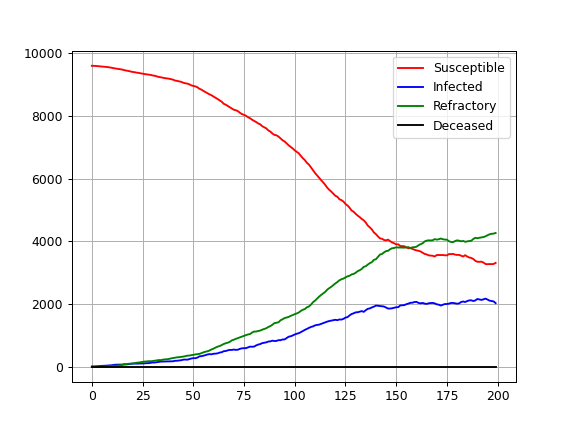

In [102]:
# SIRSmodel(n, tauI, tauR, mortality, nType, rad, bType, nsteps, skip, anim, init):
%matplotlib auto
data = SIRSmodel(100, 6, 12, 0, 0, 1, "fixed", 200, 1, True, ["corners"])
x = np.arange(len(data[0]))

plt.close("all")
plt.plot(x, data[0], '-', color = 'red')
plt.plot(x, data[1], '-', color = 'blue')
plt.plot(x, data[2], '-', color = 'green')
plt.plot(x, data[3], '-', color = 'black')
plt.legend(["Susceptible", "Infected", "Refractory", "Deceased"], loc ="upper right")

plt.grid()
plt.show()
plt.savefig("outputs/plot2.png")

# Trial modification to remove array copying; currently not working

In [14]:
def SIRSmodelNew(n, tauI, tauR, mortality, nType, rad, bType, init = ["rand", 1], nsteps = 100, skip = 1, anim = True):

    fig = plt.figure()
    grid = np.zeros((n,n,2)) #simulation grid
    now = 1; prev = 0;
    
    #set colormap and colorbar
    cmap = customCmap(tauI, tauR)
    plt.colorbar(plt.imshow(grid[:,:, prev], cmap=cmap, interpolation = 'nearest', vmin = 0, vmax = tauI+tauR+1))
    
    #data collection
    nS = np.zeros(nsteps)
    nI = np.zeros(nsteps)
    nR = np.zeros(nsteps)
    nD = np.zeros(nsteps)
    
    neighbours = np.zeros((n,n), dtype=object) #stores neighbours
    ims = []; #stores plots
    
    tau0 = tauR + tauI

    #initial conditions
    if(init[0] == "random"):
        initlist = np.random.randint(rad, n - rad, size = (int(init[1]*n), 2))
        for ind in initlist:
            grid[ind[0], ind[1], prev] = 1
            
    elif(init[0] == "single"):
        grid[init[1], init[2], prev] = 1
        
    elif(init[0] == "corners"):
        grid[rad + 2, rad + 2, prev] = 1
        grid[rad + 2, n - rad - 2, prev] = 1
        grid[n - rad - 2, rad + 2, prev] = 1
        grid[n - rad - 2, n - rad - 2, prev]  = 1         

    #boundary conditions
    if(bType == 'fixed'):
        grid[0:rad] = tau0 + 1
        grid[n-rad:n] = tau0 + 1
        grid[:, 0:rad] = tau0 + 1
        grid[:, n-rad:n] = tau0 + 1
        
    #initial count
    nS[0] = np.count_nonzero(grid[:,:,prev] == 0)
    nI[0] = sum([np.count_nonzero(grid[:,:,prev] == i) for i in range(1, tauI)])
    nR[0] = sum([np.count_nonzero(grid[:,:,prev] == i) for i in range(tauI, tau0)])
    nD[0] = 0

    
    infp = 0 #infection probability
    nb = [] #neighbour indices

    #calculate neighbours
    for i in range(n):
        for j in range(n):
            neighbours[i, j] = [np.sum([[i, j], neighbour], axis = 0)%n for neighbour in neighbourIndices(nType, rad)]
    

    #evolve loop
    for k in range(1, nsteps):
        nS[k] = nS[k-1]
        nI[k] = nI[k-1]
        nR[k] = nR[k-1]
        nD[k] = nD[k-1]
        
        #evolve
        for i in range(n):
            for j in range(n):
                
                if(grid[i, j, prev] == 0): #susceptible
                    infp = [isInfected(grid[ind[0], ind[1], prev], tauI) for ind in neighbours[i,j]].count(True)/len(neighbours[i,j])
                    
                    if(np.random.random() < infp):
                        grid[i, j, now] = grid[i, j, prev] + 1
                        nS[k] -= 1
                        nI[k] += 1

                elif(grid[i, j, prev] < tau0): #infected/refractory
                    grid[i, j, now] = grid[i, j, prev] + 1

#                     if(val <= tauI and np.random.random() < mortality): #death
#                         grid[i, j] = tau0+1 #dead
#                         nI[k] -= 1
#                         nD[k] += 1
                        
                    if(grid[i, j, prev] == tauI + 1): #transition to refractory
                        nI[k] -= 1
                        nR[k] += 1
                        
                elif(grid[i, j, prev] == tau0): #transition to susceptible
                    grid[i, j, now] = 0
                    nR[k] -= 1
                    nS[k] += 1
                
        prev = now
        now = (now + 1)%2
        
        if(k%skip == 0 and anim):
            im = plt.imshow(grid[:,:,now], animated=True, cmap = cmap, vmin = 0, vmax = tauI+tauR+1)
            ims.append([im])
    
    if(anim):
        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
        ani.save('SIRS1.mp4')
    
    return([nS, nI, nR, nD])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


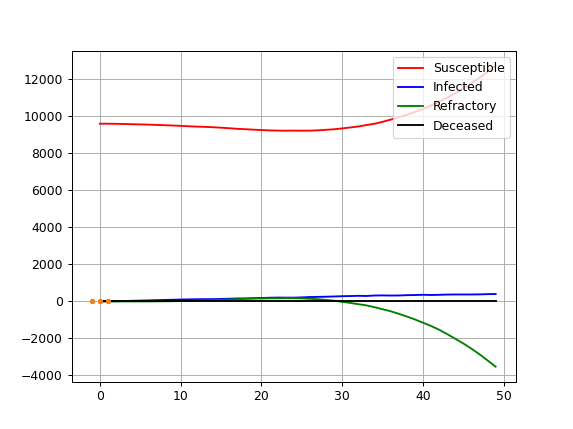

In [15]:
data = SIRSmodelNew(100, 6, 12, 0, 0, 1, "fixed",["corners"], 1, 1, True)
x = np.arange(len(data[0]))

plt.close("all")
plt.plot(x, data[0], '-', color = 'red')
plt.plot(x, data[1], '-', color = 'blue')
plt.plot(x, data[2], '-', color = 'green')
plt.plot(x, data[3], '-', color = 'black')
plt.legend(["Susceptible", "Infected", "Refractory", "Deceased"], loc ="upper right")

plt.grid()
plt.savefig("plot2.png")